## Predicting Steam Game Discounts Probabilities

Andrew Jin, Ian Lau, Meng Un, Alex Yu 

DS300

Spring 2023 



## Loading and observing data

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

df_games = pd.read_csv('games.csv')
df_games.describe().round(2)

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,46068.00,46068.00,46068.00,46068.00,46068.00,46068.00
mean,986443.12,76.76,1843.20,8.75,9.30,5.19
std,567048.71,18.20,39086.56,11.36,11.67,18.19
min,10.00,0.00,10.00,0.00,0.00,0.00
25%,501722.75,66.00,20.00,1.38,1.99,0.00
50%,916285.00,81.00,53.00,4.99,5.99,0.00
75%,1422157.50,91.00,226.00,11.99,12.99,0.00
max,2319990.00,100.00,6941137.00,299.99,299.99,90.00


This is the unedited version of the games csv that was ported from kaggle. We can see that there are roughly 46,000 games within this dataset. There are also some additional columns not apparent from the detail view on the kaggle page for this data. 

In [3]:
df_games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


This small view of the data shows the app_id, which will be the unique identifier we will be using to compare to the steamdb data for the histoical price pulling. 

## Cleaning Data
- dropping free games
- filtering dates from 2019 - March 2023

In [4]:
df_gamesFiltered = df_games[df_games['price_original'] > 0]
df_gamesFiltered.describe().round(2)

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,38698.00,38698.00,38698.00,38698.00,38698.00,38698.00
mean,957893.99,76.96,1477.14,10.39,11.07,6.17
std,564085.90,18.33,15304.71,11.67,11.94,19.69
min,10.00,0.00,10.00,0.27,0.50,0.00
25%,468422.50,67.00,20.00,2.99,3.99,0.00
50%,876865.00,81.00,50.00,6.99,7.99,0.00
75%,1386767.50,91.00,211.00,14.99,14.99,0.00
max,2319990.00,100.00,939992.00,299.99,299.99,90.00


In [5]:
df_gamesFiltered = df_gamesFiltered.astype({'date_release':'datetime64[ns]'})
df_gamesFiltered = df_gamesFiltered[df_gamesFiltered['date_release'] > '01-01-2019']

df_gamesFiltered.describe().round(2)

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,19903.00,19903.00,19903.00,19903.00,19903.00,19903.00
mean,1397368.76,79.84,1063.12,11.44,12.23,6.59
std,409650.57,17.48,10086.25,12.78,13.08,19.87
min,1313.00,0.00,10.00,0.27,0.90,0.00
25%,1099445.00,71.00,17.00,2.99,3.99,0.00
50%,1369630.00,84.00,40.00,7.99,9.99,0.00
75%,1702595.00,93.00,156.00,14.99,14.99,0.00
max,2319990.00,100.00,521326.00,199.99,199.99,90.00


## Check for blank data


In [6]:
def check_blanks(df):
    for col in df.columns:
        num_blanks = df[col].isna().sum()
        print(f"Column {col} has {num_blanks} blank values.")
check_blanks(df_gamesFiltered)

Column app_id has 0 blank values.
Column title has 0 blank values.
Column date_release has 0 blank values.
Column win has 0 blank values.
Column mac has 0 blank values.
Column linux has 0 blank values.
Column rating has 0 blank values.
Column positive_ratio has 0 blank values.
Column user_reviews has 0 blank values.
Column price_final has 0 blank values.
Column price_original has 0 blank values.
Column discount has 0 blank values.
Column steam_deck has 0 blank values.


No columns are missing data which is a good thing

## EDA Summary

After cleaning and observing the data. We have determined that there is a large disparity in prices across many titles. The largest differenced is noticable between the max and 75th percentile of the prices of games. There are also not many discount opportunities as we can see that from the 0th to the 75th percentile, there are no discount values. The overall positive review ratio are relatively good since even at the 25th percentile it is around 71% positive reviews.  

With this filtered view, we will be utilizing the app_id to only pull the necessary games from the web scraped steamdb data. This cut down of roughly 26,000 data points will be much easier to handle and will be a sufficient sample size for this project. 

# Loading SteamDB data 

In [7]:
lowest_price_df = pd.read_csv('output_file.csv')

In [8]:
merged_df = pd.merge(df_gamesFiltered, lowest_price_df, on='app_id')
merged_df.dtypes

app_id                     int64
title                     object
date_release      datetime64[ns]
win                         bool
mac                         bool
linux                       bool
rating                    object
positive_ratio             int64
user_reviews               int64
price_final              float64
price_original           float64
discount                 float64
steam_deck                  bool
lowest_price              object
dtype: object

## Cleaning lowest price

In [9]:
merged_df = merged_df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
merged_df['lowest_price'] = merged_df['lowest_price'].replace('[\$,]', '',regex=True).astype('float')


# Creating the Test-Train split data partitions

In [10]:
features = ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'lowest_price']
target = 'discount'
X = merged_df[features]
y = merged_df[target]
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)



# Scaling the numeric data 

In [11]:
X_train = X_train.copy()
X_test = X_test.copy()

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[features]) #all of our features are numeric

X_train[features] = scaler.transform(X_train[features])

In [13]:
X_train.head()

,positive_ratio,user_reviews,price_final,price_original,lowest_price
11387,1.040593,-0.105156,-0.119981,-0.177107,-0.361159
13611,-0.276904,-0.110576,-0.507559,-0.556179,-0.690830
9639,0.066791,-0.076674,-0.817622,-0.859436,-0.759511
6389,0.983311,-0.107281,-0.507559,-0.556179,-0.484786
664,0.639616,-0.093040,0.267598,0.201965,-0.374895


In [14]:
X_train = X_train.fillna(0) #filling in the few blanks from the lowest price variable

In [15]:
#Scaling features
svm = SVC()
svm.fit(X_train,y_train)
X_test[features] = scaler.transform(X_test[features])

### We will be building out the algorithms in the order of Logistic Regression, Random Forest Regression, and XGBoost (known as gradient boost). This order is on purpose to show why the first two algorithms were not the right ones for our project. These algorithms will follow the same format of building the inital model - hyperparameter tuning - implementing hyperparameters to the model - cross validation. Only the XGBoost model will move further due to it being the best algorithm for our project.

# Building the Logistics Regression model

In [15]:
log_reg = LogisticRegression(penalty = 'l2',
                             C = 0.01,
                             fit_intercept = True,
                             solver = 'newton-cg',
                             max_iter = 100,
                             multi_class = 'ovr')
log_reg.fit(X_train, y_train)


LogisticRegression(C=0.01, multi_class='ovr', solver='newton-cg')

In [16]:
print('Accuracy score', log_reg.score(X_test,y_test).round(4))

Accuracy score 0.8872


# Logistic Regression Hyperparameter tuning

In [17]:
log_params = {'penalty':  ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.arange(1,50,5),
              'fit_intercept': [True, False],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': np.arange(100,1500,100),
              'multi_class': ['ovr', 'multinomial']}

log_grid = RandomizedSearchCV(
    log_reg,
    param_distributions=log_params,
    n_iter=10,
    cv=5,
    random_state=42
)
log_grid.fit(X_train,y_train)

print('These are the best Parameters for this model',log_grid.best_params_)
print('This is the best possible score',log_grid.best_score_.round(4))


c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: 

These are the best Parameters for this model {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'max_iter': 300, 'fit_intercept': False, 'C': 26}
This is the best possible score 0.9237


### These were the outputs from the block above, we had to collapse the output due to it taking up too much space:
These are the best Parameters for this model {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'max_iter': 300, 'fit_intercept': False, 'C': 26}

This is the best possible score 0.9237

In [18]:
log_reg = LogisticRegression(penalty = 'l2',
                             C = 26,
                             fit_intercept = False,
                             solver = 'newton-cg',
                             max_iter = 300,
                             multi_class = 'multinomial')
log_reg.fit(X_train, y_train)


LogisticRegression(C=26, fit_intercept=False, max_iter=300,
                   multi_class='multinomial', solver='newton-cg')

In [19]:
print('Accuracy score after hyperparameter tuning', log_reg.score(X_test,y_test).round(4))

Accuracy score after hyperparameter tuning 0.9314


# Logisitc Regression Cross Validation

c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score

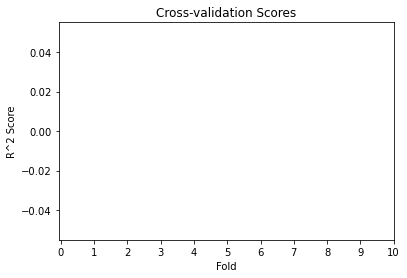

In [20]:
# Cross validation 

#Cross Validation Fold line plot
cv = 10
log_scores = cross_val_score(log_reg, X, y, cv=cv, scoring='r2')

plt.plot(log_scores)
plt.xlabel('Fold')
plt.xticks(range(cv+1))
plt.ylabel('R^2 Score')
plt.title('Cross-validation Scores')
plt.show()


In [21]:
# Print the mean and standard deviation of the scores
print('Mean R^2 score:', np.mean(log_scores).round(3))
print('Standard deviation of R^2 scores:', np.std(log_scores).round(3))

Mean R^2 score: nan
Standard deviation of R^2 scores: nan


The issue here is that since Logistic regressions do not accept nan values natively for cross validation. We cannot assess the accuracy of the model. We could fix that issue via filling in the values, however, we do have other algorithms that we can utilize that does accept nan values natively. Thus, Logistic regression will not be the algorithm that we are going to utilize for this project. 

# Building the Random Forest Regression Model

In [22]:
rand_for_reg = RandomForestRegressor(n_estimators=100,
                                     max_depth=10,
                                     min_samples_split=2,
                                     min_samples_leaf=2,
                                     random_state=42)
rand_for_reg.fit(X_train,y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=2, random_state=42)

In [23]:
print('Accuracy score', rand_for_reg.score(X_test,y_test).round(4))

Accuracy score 0.9941


# Random Forest Regression Hyperparameter Tuning

In [24]:
rand_for_params = {'n_estimators': np.arange(50,500,50),  
                  'max_depth': np.arange(1,50,10),  
                  'min_samples_split': np.arange(1,10),  
                  'min_samples_leaf': np.arange(1,10)}

rand_for_grid = RandomizedSearchCV(
    rand_for_reg,
    param_distributions=rand_for_params,
    n_iter=10,
    cv=5,
    random_state=42
)
rand_for_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=10,
                                                   min_samples_leaf=2,
                                                   random_state=42),
                   param_distributions={'max_depth': array([ 1, 11, 21, 31, 41]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42)

In [25]:
print('These are the best Parameters for this model',rand_for_grid.best_params_)
print('This is the best possible score',rand_for_grid.best_score_.round(4))

These are the best Parameters for this model {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 41}
This is the best possible score 0.9946


In [26]:
rand_for_reg = RandomForestRegressor(n_estimators=300,
                                     max_depth=41,
                                     min_samples_split=2,
                                     min_samples_leaf=3,
                                     random_state=42)
rand_for_reg.fit(X_train,y_train)


RandomForestRegressor(max_depth=41, min_samples_leaf=3, n_estimators=300,
                      random_state=42)

In [27]:
print('Accuracy score after hyperparameter tuning', rand_for_reg.score(X_test,y_test).round(4))

Accuracy score after hyperparameter tuning 0.9968


# Random Forest Regression Cross validation

c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "c:\Users\Rival\OneDrive\Documents\Python Scripts\lib\site-packages\sklearn\ensemble\_forest.py", line 981, in predict
    X = self._validate_X_predict(X)
  File "c:\Users\Riv

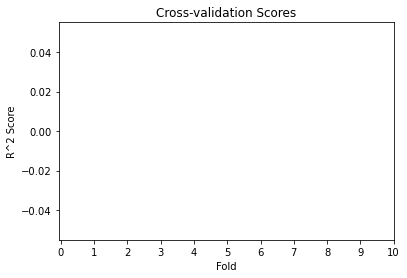

In [28]:
# Cross validation 

#Cross Validation Fold line plot
cv = 10
rand_scores = cross_val_score(rand_for_reg, X, y, cv=cv, scoring='r2')

plt.plot(rand_scores)
plt.xlabel('Fold')
plt.xticks(range(cv+1))
plt.ylabel('R^2 Score')
plt.title('Cross-validation Scores')
plt.show()


In [29]:
# Print the mean and standard deviation of the scores
print('Mean R^2 score:', np.mean(rand_scores).round(3))
print('Standard deviation of R^2 scores:', np.std(rand_scores).round(3))

Mean R^2 score: nan
Standard deviation of R^2 scores: nan


Although both algorithms had high accuracy scores after the hypertuning, both the Logistics Regression and Random Forest Regression cross validations did not work due to Nan values. Also, for both the algorithms, it took more than 2 minutes for the randomized search cv and fit to process. This is ineffective because from what we can see later, the randomized search cv was much more efficient for the XGBoost algorithm. As well as the fact that no other data manipulation steps were needed in order to cross validate the XGBoost model. 

Since both algorithms could not even get passed the cross validation model, we thought it was better for us to move onto XGBoost since we cannot effectively assess the accuracy of the model.

# Building the XGBoost prediction model 

In [16]:
# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 100)


xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

These initial metrics were a simple guess based on the most common ranges for these hyper parameters

In [17]:
print('Accuracy score', xg_reg.score(X_test,y_test).round(4))

Accuracy score 0.6297


# XGBoost Hyper Parameter Tuning

In [18]:


params = {'alpha': np.arange(1,25),
          'max_depth': np.arange(1,25),
          'learning_rate': np.arange(0,1,0.1).round(1),
          'colsample_bytree': np.arange(0,1,0.1).round(1),
          'n_estimators': np.arange(50,500,20)}

xgb_grid = RandomizedSearchCV(
    xg_reg,
    param_distributions=params,
    n_iter=10,
    cv=5,
    random_state=42
)
xgb_grid.fit(X_train,y_train)

print('These are the best Parameters for this model',xgb_grid.best_params_)
print('This is the best possible score',xgb_grid.best_score_.round(4))


These are the best Parameters for this model {'n_estimators': 290, 'max_depth': 3, 'learning_rate': 0.8, 'colsample_bytree': 0.5, 'alpha': 21}
This is the best possible score 0.9886


The reason for using a randomized search rather than a grid search is to save a lot of time. We tried to make the grid search work by giving it a smaller sample as well as cutting of the number of iterations it did to 10, but to no avail, it still took too much time and resources. The Randomized search works just as well as can be seen by the best possible score that was obtained, 98.86%. 

## XGBoost Hyper Parameter tuning results application

In [19]:
# New model with outputs from best params
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.5, 
                          learning_rate = 0.8,
                          max_depth = 3, 
                          alpha = 21, 
                          n_estimators = 290)

xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=21, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.8, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=290, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [20]:
print('Accuracy score after hyperparameter tuning', xg_reg.score(X_test,y_test).round(4))

Accuracy score after hyperparameter tuning 0.9917


After applying the results from the Hyper Parameter tuning, the best score we got was actually higher than the random search prediction at 99.17%. This was a massive improvement from the initial model that had a 62.97% accuracy rating.

# XGBoost Cross Validation

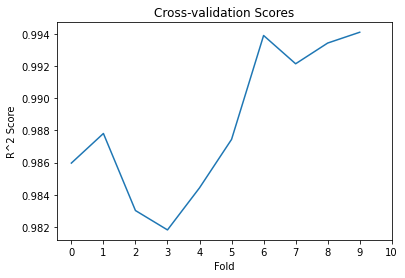

In [21]:
# Cross validation 

#Cross Validation Fold line plot
cv = 10
xgb_scores = cross_val_score(xg_reg, X, y, cv=cv, scoring='r2')

plt.plot(xgb_scores)
plt.xlabel('Fold')
plt.xticks(range(cv+1))
plt.ylabel('R^2 Score')
plt.title('Cross-validation Scores')
plt.show()


In [22]:
# Print the mean and standard deviation of the scores
print('Mean R^2 score:', np.mean(xgb_scores).round(3))
print('Standard deviation of R^2 scores:', np.std(xgb_scores).round(3))

Mean R^2 score: 0.988
Standard deviation of R^2 scores: 0.004


The cross validation scores line chart is hovering above a 98% R^2 score. We can make the inference that this model is performing well, especially since the mean R^2 score is also very high at 98.8% as well as the fact that the standard deviation being relatively low at 0.004. This low standard deviation also means that there is less variability in the data and suggests that the R^2 scores are consistent and close to the mean score as well as the data points being grouped closely together. 

In [23]:
importance = xg_reg.feature_importances_

# Print feature importances
for i in range(len(importance)):
    print(f'Feature {i+1}: Importance = {importance[i]}')

Feature 1: Importance = 0.02571968361735344
Feature 2: Importance = 0.011099179275333881
Feature 3: Importance = 0.4039747714996338
Feature 4: Importance = 0.4907691478729248
Feature 5: Importance = 0.06843719631433487


The order of the features go ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'lowest_price']. This means that the most important feature is the original price of the game, followed by the final price of the game. The least important features are the user reviews and positive ratio of the game. This is an interesting find for our model.

# XGBoost Probability Prediction Visualizations

In [24]:
y_pred = xg_reg.predict(X_test)

# Convert the predicted probabilities to probabilities between 0 and 1 using Min-Max scaling
scaler_prob = MinMaxScaler()
y_pred_prob = scaler_prob.fit_transform(y_pred.reshape(-1,1))

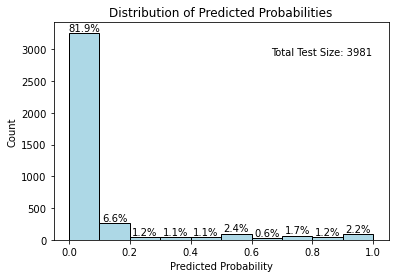

In [25]:
#VISUALIZATION 

bins = np.linspace(0, 1, 11) #specifying the number of bins in this visualization

# Plot histogram of predicted probabilities for the full range
plt.hist(y_pred_prob, bins=10, color='lightblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')

# Adding text labels on top of the bars
total_count = len(y_pred_prob)
for i in range(len(bins) - 1):

    count = np.sum((y_pred_prob >= bins[i]) & (y_pred_prob < bins[i + 1])) #the number of data points in each bin
    percentage = count / len(y_pred_prob) * 100 #percentage that is going to be shown on top of the bar

    #the percentage on top of the bins
    plt.text((bins[i] + bins[i + 1]) / 2, count, f'{percentage:.1f}%', ha='center', va='bottom', color='black')

# Showing sample size for the full test size 
plt.text(0.95, 0.85, f'Total Test Size: {total_count}', transform=plt.gca().transAxes, ha='right', color='black')

plt.show()


As we can see, almost 82%, 3,260 games, of the test size of games reside in the first bin between 0 and 0.1. What this tells us is that most games will either have a 0 or 10% chance of going on sale. The rest of the distribution is split into 9 more bins with only about 18% of the test set left. This visualization shows us a very good representation on the grand scheme of things, however, we want to dive deeper and see more about how many games could have a higher chance of going on sale. Thus, we made another visualization of probabilities above 50% below. 

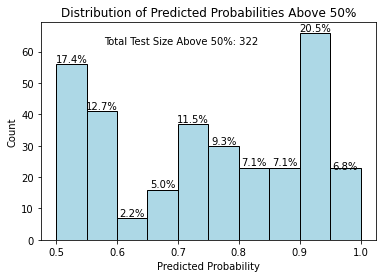

In [26]:
# Visualization for Predictions above 50%

# New bin sizing for probabilities above 50%
bins50p = np.linspace(0.5, 1.0, num = 11)

# Plot histogram of predicted probabilities for the probilities above 50%
plt.hist(y_pred_prob, bins=10, range=(0.5,1.0), color='lightblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities Above 50%')

# Above 50% totals
total_count_above_50 = np.sum(y_pred_prob >= 0.5)
total_percentage_above_50 = total_count_above_50 / total_count * 100


for i in range(len(bins50p) - 1):


    count = np.sum((y_pred_prob >= bins50p[i]) & (y_pred_prob < bins50p[i + 1])) #the number of data points in each bin
    percentage_above_50 = count / total_count_above_50 * 100  #calculate percentage of count relative to total count above 50%

    if bins50p[i] >= 0.5:  # Only show labels for bins with values >= 50%

        #the percentage on top of the bins
        plt.text((bins50p[i] + bins50p[i + 1]) / 2, count, f'{percentage_above_50:.1f}%', ha='center', va='bottom', color='black')


# Add total sample size above 50% as a text label
plt.text(0.65, 0.90, f'Total Test Size Above 50%: {total_count_above_50}', transform=plt.gca().transAxes, ha='right', color='black')

plt.show()


This is the distribution of probabilities above 50% with only 322 test data points. What we can see is that there are many games that could go on sale with the biggest bin being between 0.9 and 0.95 at 20.5% of the test data points. We can see much less of a trend compared to the general overview for the full range of test data points above. Since 322 is about 1% of the total test data size we can make the observation that most games will probably not go on sale. 

# Overview and observations

As we have concluded, most games will not go on sale. We have slightly altered our main prompt for this project from whether games will go on sale to what is the likelihood of games going on sale. We think that our previous prompt definitely required more time and data, both things we currently do not have at the moment. However, based on our XGBoost model, we can make a strong inference that since only about 1% of games from the test data size had a 50% chance or higher of going on sale, most games in the overall data will most likely not go on sale either. Essentially our answer to our prompt is of the mindset that it is extremely unlikely a game goes on sale based on ratings alone. There is definitely more at play than simply looking at ratings as one of the main contributing factors to the probability of games going on sale. 